In [1]:
#########################################################################################
# Data Science Training Workshop: Using Jupyter Notebook and R (with a little Spark)
# Presenters: Leslie McIntosh, PhD, MPH; Connie Zabarovskaya, MITM; Lorinette Wirth, MPH
# 
# This script uses full_surgcode_data_sample, where records with NAs were not removed
# This ensures better representation of data and realistic survivability rate.
# This script breaks down the data_sample into training and test datasets, and runs C5.0
# Decision tree algorithm with different controls. We also calculate performance evaluation 
# measures for each model.
#########################################################################################

In [2]:
# ON DOCKER: If you're not using conniez/all-spark-notebook image, uncomment the install command. 
# This needs to be run only once per container run (so the package is installed)
# suppressWarnings(suppressMessages(install.packages("C50", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")))
# ON ANACONDA: If you haven't yet installed C50 package, uncomment this command
# suppressWarnings(suppressMessages(install.packages("C50", repo="http://cran.us.r-project.org")))

In [3]:
# FULL DATASET - WITH NAs
# load data
load("full_surgcode_data_sample.rdata")
# for easiness of use, let's shorten the name of the loaded dataset to be data_sample
data_sample <- full_surgcode_data_sample

In [4]:
# classification variable must be of factor type
data_sample$survived <- as.factor(data_sample$survived)

In [5]:
round(table(data_sample$survived)/nrow(data_sample),2)


   0    1 
0.28 0.72 

In [6]:
# create the train and test sets 
set.seed(5)
# Use 80% of data for training dataset
train <- sample(1:nrow(data_sample), nrow(data_sample)*0.8)
test <- -train
data_sample_train <- data_sample[train,]
data_sample_test <- data_sample[test,]

In [7]:
# load C50 library and run C5.0 fit
library(C50)
# takes slightly over 20sec
fittime <- proc.time()
C50fit <- C5.0(survived~., data=data_sample_train, trials=1)
proc.time() - fittime

   user  system elapsed 
 22.330   0.080  22.439 

In [8]:
print(C50fit)

# You can capture the long summary of fit and write it to a txt file for review
s <- summary(C50fit)
capture.output(s, file = "full_C50fitsummary.txt")


Call:
C5.0.formula(formula = survived ~ ., data = data_sample_train, trials = 1)

Classification Tree
Number of samples: 190765 
Number of predictors: 17 

Tree size: 262 

Non-standard options: attempt to group attributes



In [9]:
# Function to plot variable importance
plotVarImportance <- function(model){
    varImp <- as.data.frame(C5imp(model))
    varImp$var <- row.names(varImp)
    barplot(varImp$Overall,names.arg=varImp$var, main="Variable Importance", las=2, cex.names=0.7)
}

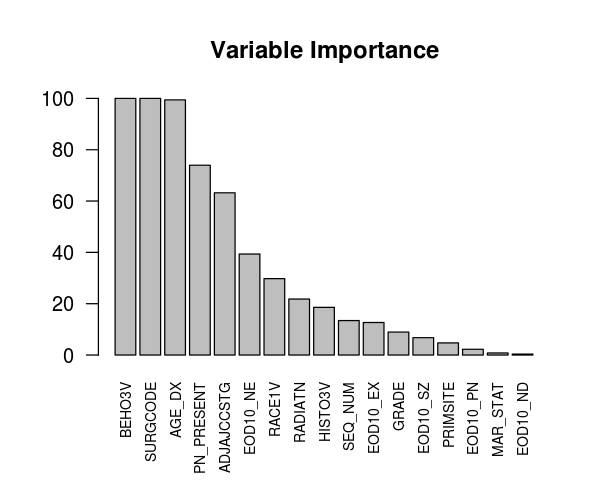

In [10]:
options(repr.plot.width=5, repr.plot.height=4)
# Plot variable importance using the function created above
plotVarImportance(C50fit)

In [11]:
# Run predictions using C50fit model and store them in predictions variable
predictions <- predict(C50fit, data_sample_test)

In [12]:
# ON DOCKER: If you're not using conniez/all-spark-notebook image, uncomment the install command. 
# This needs to be run only once per container run (so the package is installed)
# suppressWarnings(suppressMessages(install.packages("dplyr", lib="/opt/conda/lib/R/library", repo="http://cran.us.r-project.org")))
# ON ANACONDA: If you haven't yet installed dplyr package, uncomment this command
# suppressWarnings(suppressMessages(install.packages("dplyr", repo="http://cran.us.r-project.org")))

In [13]:
suppressWarnings(suppressMessages(library(dplyr)))
# Function to calculate accuracy, sensitivity, specificity and other performance evaluation metrics
evaluatePerformance <- function(predictions, actualvalues, method_name){
    require(dplyr)
    comparison_data<-data.frame(predicted = predictions,survived = actualvalues)
    measures <- comparison_data %>% mutate(compared = ifelse(predicted == survived & predictions == 0, 'TN',
                                           ifelse(predicted == survived & predicted == 1, 'TP',
                                           ifelse(predicted != survived & predicted == 0, 'FN',
                                           ifelse(predicted != survived & predicted == 1, 'FP',NA))))
                                          ) %>% group_by(compared) %>% summarise(freq = length(compared)) 
    mlist <- as.list(measures$freq)
    names(mlist) <- measures$compared 
    # Accuracy:  (TP + TN)/(TP + TN + FP + FN)
    accuracy <- (mlist$TP+mlist$TN)/(mlist$TP + mlist$TN + mlist$FP + mlist$FN)
    # Misclassification rate/Error Rate: (FP + FN)/(TP + TN + FP + FN)
    error<- (mlist$FP + mlist$FN)/(mlist$TP + mlist$TN + mlist$FP + mlist$FN) 
    # Sensitivity / Recall / True Positive Rate:  TP/(TP + FN)
    sensitivity <- mlist$TP/(mlist$TP + mlist$FN)
    # Specificity:  TN/(TN + FP)
    specificity <- mlist$TN/(mlist$TN + mlist$FP)
    # Prevalence: (TP+FN)/(TP + TN + FP + FN)
    prevalence <- (mlist$TP + mlist$FN)/(mlist$TP + mlist$TN + mlist$FP + mlist$FN)
    # Precision / Positivie Predictive Value (PPV): TP/(TP + FP)
    PPV <- mlist$TP/(mlist$TP + mlist$FP)
    # Negative Predictive Value (NPV): TN/(TN + FN)
    NPV <- mlist$TN/(mlist$TN + mlist$FN)

    # Source: https://en.wikipedia.org/wiki/Cohen's_kappa
    # Kappa = (observed accuracy - expected accuracy)/(1 - expected accuracy)
    # expected accuracy, or overall probability of random agreement
    marginalA <- ((mlist$TP + mlist$FP) * (mlist$TP + mlist$FN))/(mlist$TP + mlist$TN + mlist$FP + mlist$FN)
    marginalP <- ((mlist$FN + mlist$TN) * (mlist$FP + mlist$TN))/(mlist$TP + mlist$TN + mlist$FP + mlist$FN)
    expected <- (marginalA + marginalP)/ (mlist$TP + mlist$TN + mlist$FP + mlist$FN)
    Kappa <-  (accuracy - expected)/(1-expected)
    
    data.frame(Technique = method_name, 
               Accuracy = paste0(round(accuracy,3)*100, "%"),
               Error_Rate = paste0(round(error,3)*100, "%"),
               Sensitivity = paste0(round(sensitivity,3)*100, "%"),
               Specificity = paste0(round(specificity,3)*100, "%"),
               Prevalence = paste0(round(prevalence,3)*100, "%"),
               PPV = paste0(round(PPV,3)*100, "%"),
               NPV = paste0(round(NPV,3)*100, "%"),
               Kappa = paste0(round(Kappa,3)*100, "%"))
}

In [14]:
# Summarize performance evaluation for the model
evaluatePerformance(predictions,data_sample_test$survived, "C5.0")

Technique,Accuracy,Error_Rate,Sensitivity,Specificity,Prevalence,PPV,NPV,Kappa
C5.0,86.1%,13.9%,94.2%,65.4%,71.7%,87.4%,81.6%,63.4%


In [15]:
# Lowering CF control for C5.0 model will produce a smaller tree

# We run several versions of controlled C5.0 in order to get an idea of how CF value affects the model
# Default CF value is 0.25, we increment it by 0.05 in both directions.
C50fitcontrolled_10 <- C5.0(survived~., data=data_sample_train, trials = 1,control = C5.0Control(CF= 0.10))

C50fitcontrolled_15 <- C5.0(survived~., data=data_sample_train, trials = 1,control = C5.0Control(CF= 0.15))

C50fitcontrolled_30 <- C5.0(survived~., data=data_sample_train, trials = 1,control = C5.0Control(CF= 0.30))

In [16]:
print(C50fitcontrolled_10)


Call:
C5.0.formula(formula = survived ~ ., data = data_sample_train, trials =
 1, control = C5.0Control(CF = 0.1))

Classification Tree
Number of samples: 190765 
Number of predictors: 17 

Tree size: 106 

Non-standard options: attempt to group attributes, confidence level: 0.1



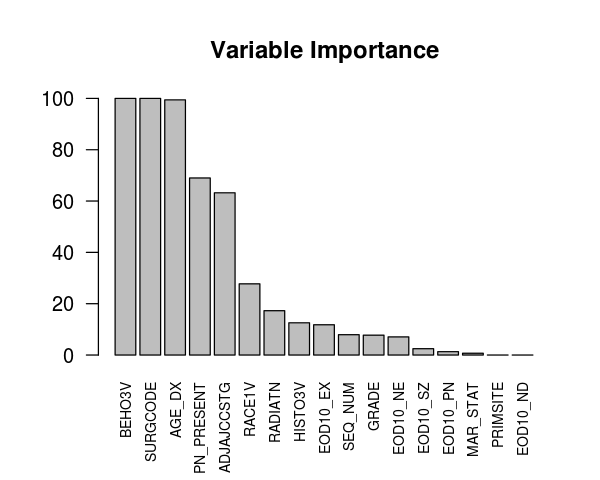

In [17]:
# Plot variable importance
plotVarImportance(C50fitcontrolled_10)

# The Variable importance doesn't seem to be affected too much

In [18]:
# run predictions using the additional models
predict_contr_10 <- predict(C50fitcontrolled_10, data_sample_test)
predict_contr_15 <- predict(C50fitcontrolled_15, data_sample_test)
predict_contr_30 <- predict(C50fitcontrolled_30, data_sample_test)

# compare the performance of different model versions
rbind(
      evaluatePerformance(predict_contr_10,data_sample_test$survived, "C5.0 with CF 0.10"),
      evaluatePerformance(predict_contr_15,data_sample_test$survived, "C5.0 with CF 0.15"),
      evaluatePerformance(predictions,data_sample_test$survived, "C5.0 with CF 0.25"),
      evaluatePerformance(predict_contr_30,data_sample_test$survived, "C5.0 with CF 0.30"))

Technique,Accuracy,Error_Rate,Sensitivity,Specificity,Prevalence,PPV,NPV,Kappa
C5.0 with CF 0.10,85.9%,14.1%,94.3%,64.7%,71.7%,87.1%,81.6%,62.9%
C5.0 with CF 0.15,86%,14%,94.4%,64.6%,71.7%,87.1%,82%,63.1%
C5.0 with CF 0.25,86.1%,13.9%,94.2%,65.4%,71.7%,87.4%,81.6%,63.4%
C5.0 with CF 0.30,86.1%,13.9%,94.2%,65.4%,71.7%,87.4%,81.7%,63.5%


In [19]:
# Compare the tree sizes of 4 models
paste0("Tree size for C5.0 model with CF 0.10: ", C50fitcontrolled_10$size)
paste0("Tree size for C5.0 model with CF 0.15: ", C50fitcontrolled_15$size)
paste0("Tree size for C5.0 model with CF 0.25: ", C50fit$size)
paste0("Tree size for C5.0 model with CF 0.30: ", C50fitcontrolled_30$size)

[1] "Tree size for C5.0 model with CF 0.10: 106"

[1] "Tree size for C5.0 model with CF 0.15: 142"

[1] "Tree size for C5.0 model with CF 0.25: 262"

[1] "Tree size for C5.0 model with CF 0.30: 321"

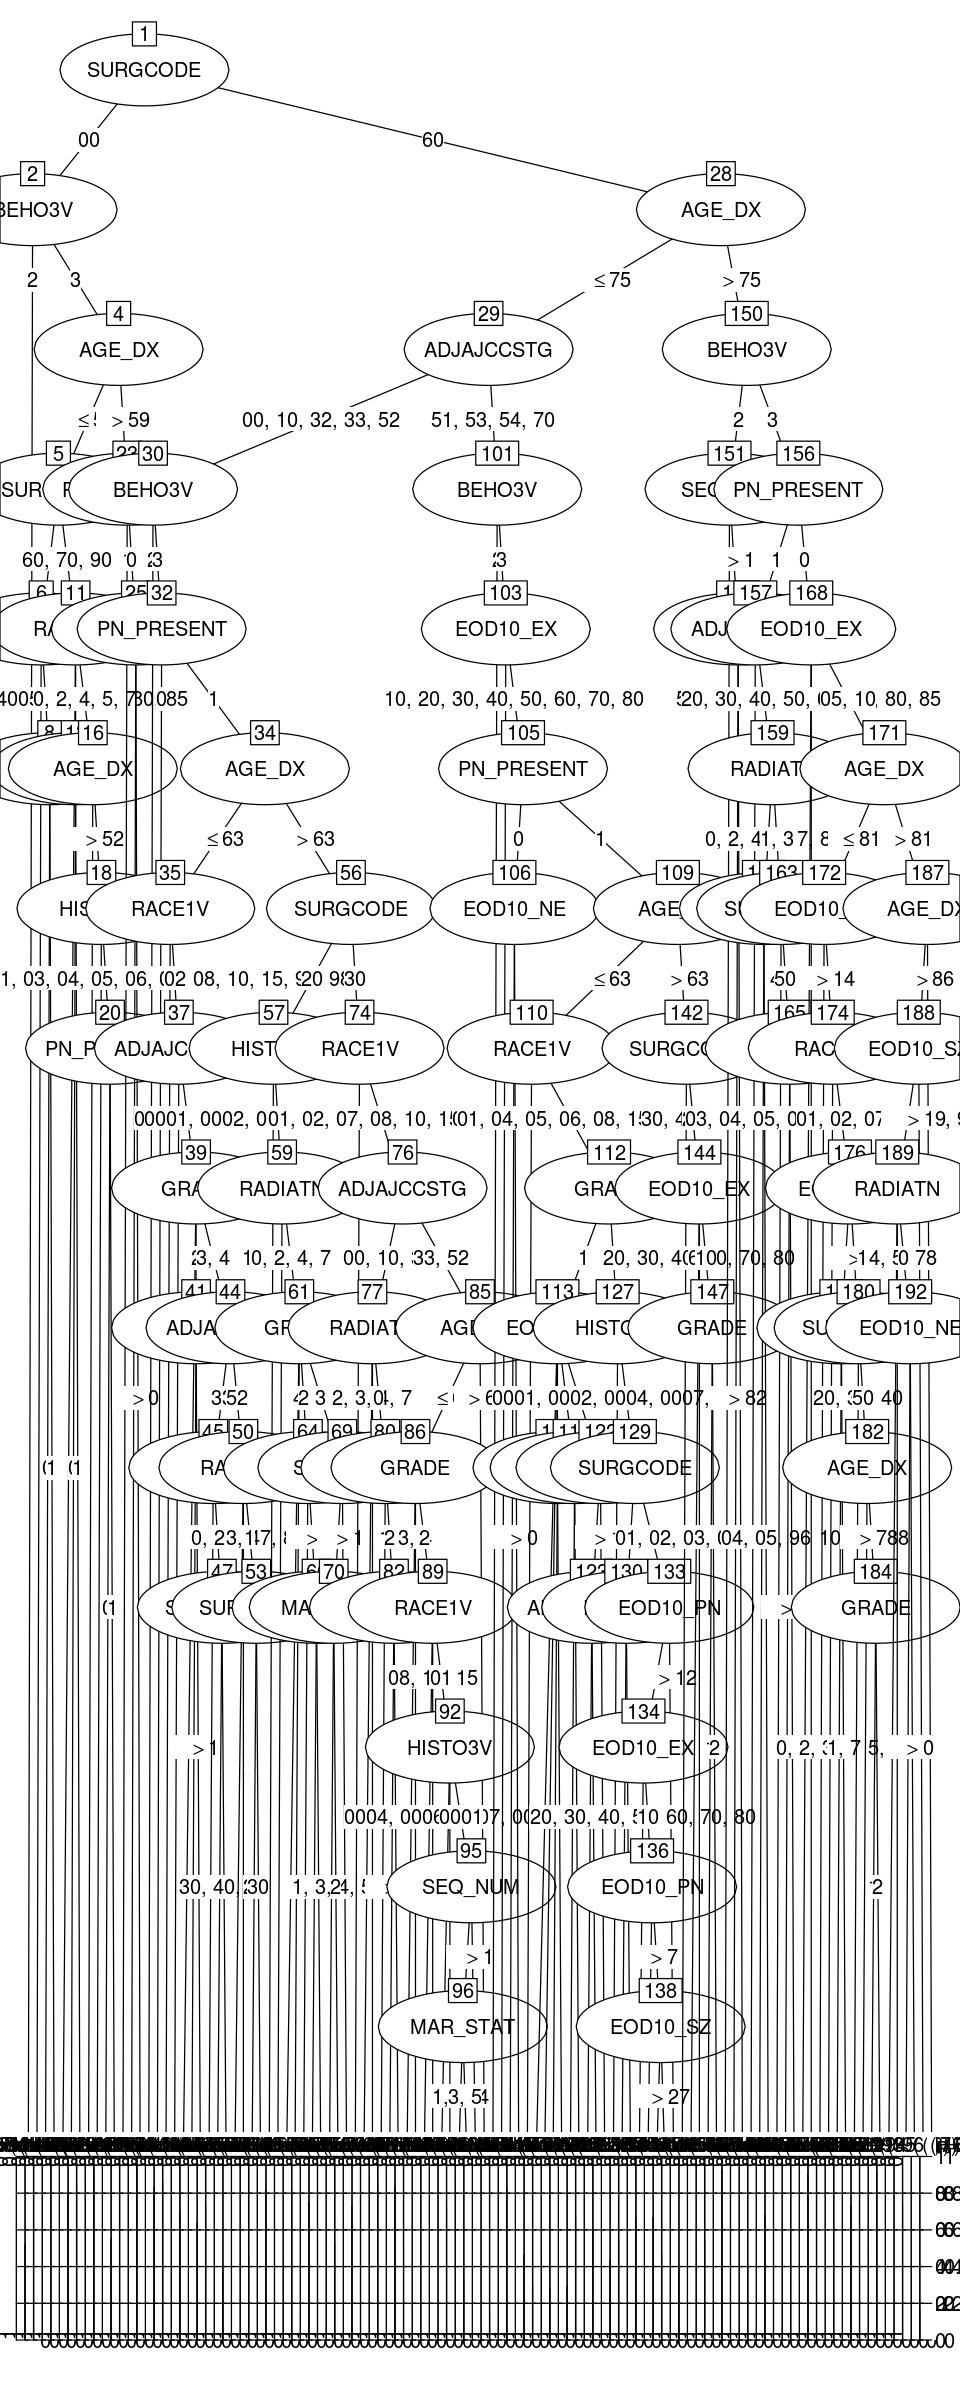

In [20]:
# Attempt at plotting
options(repr.plot.width=8, repr.plot.height=20)
plot(C50fitcontrolled_10)